Christopher Chan DS636 Midterm Project

In [12]:
library(dplyr)
library(lubridate)
library(tidyverse)
update.packages("ggplot2")
library(ggplot2)

In [13]:
# Read tables

AAPL <- read_csv("/content/sample_data/AAPL.csv")
AMZN <- read_csv("/content/sample_data/AMZN.csv")
GOOG <- read_csv("/content/sample_data/GOOG.csv")
IBM <- read_csv("/content/sample_data/IBM.csv")
META <- read_csv("/content/sample_data/META.csv")
MSFT <- read_csv("/content/sample_data/MSFT.csv")
NFLX <- read_csv("/content/sample_data/NFLX.csv")
SAP <- read_csv("/content/sample_data/SAP.csv")
ORCL <- read_csv("/content/sample_data/ORCL.csv")
TSLA <- read_csv("/content/sample_data/TSLA.csv")
JPYUSD <- read_csv("/content/sample_data/JPYUSD.csv")

Rows: 250 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 250 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 250 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): Open, High, Low, Close, Adj Close, Volume
date (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to qui

In [14]:
share_holding <- list(
  "IBM" = 0,
  "MSFT" = 0,
  "GOOG" = 0,
  "AAPL" = 0,
  "AMZN" = 0,
  "META" = 0,
  "NFLX" = 0,
  "TSLA" = 0,
  "ORCL" = 0,
  "SAP" = 0
)

# Create a list of stock dataframes
universe <- list(
  "IBM" = IBM,
  "MSFT" = MSFT,
  "GOOG" = GOOG,
  "AAPL" = AAPL,
  "AMZN" = AMZN,
  "META" = META,
  "NFLX" = NFLX,
  "TSLA" = TSLA,
  "ORCL" = ORCL,
  "SAP" = SAP
)


In [15]:
print(names(universe))

 [1] "IBM"  "MSFT" "GOOG" "AAPL" "AMZN" "META" "NFLX" "TSLA" "ORCL" "SAP" 


High Index

In [16]:
# Creates the dataframe for the high tech index by finding the simple average of stock prices everyday

high_tech_index <- c()
date_list <- c()

for (index in 1:(nrow(universe[["IBM"]]))) {
  average_price <- 0
  for (name in names(universe)){
    average_price <- average_price + universe[[name]][index, "Close"]
  }

  average_price <- average_price / length(names(universe))

  if (index == 1){
    initial_price <- average_price
  }

  percent_change <- (average_price / initial_price * 100) - 100

  high_tech_index <- c(high_tech_index, percent_change)
  date_list <- c(date_list, universe[[name]][index, "Date"]$Date[1])
}

high_tech_index <- unlist(high_tech_index)

# Dataframe for the percent change in average stock price compared to the initial
index_df <- data.frame(Date = as.Date(date_list), Percent = high_tech_index)

In [17]:
# Preprocessing the dataframe by filtering the dates where no rebalance occurs

# Given the dataframe and days (the frequency of rebalance)
data_processing <- function(df, days) {

  # Keeps the first date, last date, and every nth day
  result <- df[c(1, which((1:(nrow(df) - 1)) %% days == 0) + 1), ]
  if (nrow(df) - 1 %% days != 0) {
    result <- rbind(result, df[nrow(df), ])
  }
  result <- result %>% mutate(price_difference = (`Adj Close` - lag(`Adj Close`, n = 1)) / lag(`Adj Close`, n = 1) * 100)
  return(result)
}

In [18]:
# Apply the preprocessing for all dataframes in the universe list
processed_universe <- lapply(universe, data_processing, 5)

In [19]:
# Script to find if the stock has dividends

# Preprocessing
find_dividends <- function(df) {
  close_ratio <- c(NA, df$Close[-nrow(df)] / df$Close[-1] )
  adj_close_ratio <- c(NA, df$`Adj Close`[-nrow(df)] / df$`Adj Close`[-1])
  df$close_ratio <- close_ratio
  df$adj_close_ratio <- adj_close_ratio
  df$diff <- abs(df$close_ratio - df$adj_close_ratio)
  df$div <- df$diff * df$Close
  df <- df %>% filter(diff > 0.0001)
  df <- df %>% select(Date, div)
  return(df)
}

universe <- list(
  "IBM" = IBM,
  "MSFT" = MSFT,
  "GOOG" = GOOG,
  "AAPL" = AAPL,
  "AMZN" = AMZN,
  "META" = META,
  "NFLX" = NFLX,
  "TSLA" = TSLA,
  "ORCL" = ORCL,
  "SAP" = SAP
)

# Puts all the stock dividend in a list of dataframes
dividends <- lapply(universe, find_dividends)


In [20]:
# Script to find the current holding worth, buying/selling stock, finding new stocks, and adding in dividends

# Script Flow:
# 1. Initial Buy
# 2. Iterate to next index
# 3. Sell holding
# 4. Check for dividends in the date range between bought and sell
# 5. Find new stocks to buy (selection == low -> buy the stocks that drop the most, selection == high -> buy the stock that gain the most)
# 6. Buy stocks
# 7. Repeat steps 2-7

run_script <- function(selection, current, initial_buy, budget, jpy){

  # Sell stock function
  sell_stock <- function(share_holding, rebalance_index){
    # Sets the current price to the remaining from buying earlier
    current <<- remaining

    # Iterate through all stocks
    for (i in names(share_holding)){
      # If we are holding the stock, we sell the stock and add it to current
      if (share_holding[[i]] > 0){

        # If JPYUSD we calc differently
        if (i != "JPYUSD"){
          sale_price <- share_holding[[i]] * processed_universe[[i]][rebalance_index, "Close"]
          # print(c(i, sale_price, processed_universe[[i]][rebalance_index, "Close"]))
          # print(sale_price)
          current <<- current + sale_price
        }
        else if (i == "JPYUSD"){
          sale_price <- share_holding[[i]] / processed_universe[[i]][rebalance_index, "Close"]
          # print(c(i, sale_price, processed_universe[[i]][rebalance_index, "Close"]))
          # print(sale_price)
          current <<- current + sale_price
        }
      }

      # Set the stock holding to 0
      share_holding[[i]] <<- 0
    }
  }

  # Buy stock function
  buy_stock <- function(stock_name, budget, rebalance_index){
    if (stock_name != "JPYUSD"){

      # Determines number of shares with the budget and stock price
      share <- floor(budget / processed_universe[[stock_name]][rebalance_index, "Close"])
      share_holding[[stock_name]] <<- 0

      # Adds the share to the portfolio
      share_holding[[stock_name]] <<- share

      # Subtracts what we have left
      current <<- current - share * processed_universe[[stock_name]][rebalance_index, "Close"]
    }
    else if (stock_name == "JPYUSD"){

      # Determines yen with the budget and conversion
      share <- budget * processed_universe[[stock_name]][rebalance_index, "Close"]

      share_holding[[stock_name]] <<- 0

      # Adds the share to the portfolio
      share_holding[[stock_name]] <<- share

      # Subtract budget since we fully convert the budget to buying yen
      current <<- current - budget
    }

  }

  # Check dividends function
  check_dividends <- function(dividends, rebalance_index, share_holding){
    cur <- 0

    for (i in names(share_holding)){
      # If holding is greater than 0
      if (i != "JPYUSD"){
        if (share_holding[[i]] > 0 & nrow(dividends[[i]]) != 0){
          date1 <- as.Date(processed_universe[[i]][rebalance_index - 1, "Date"]$Date[1])
          date2 <- as.Date(processed_universe[[i]][rebalance_index, "Date"]$Date[1])

          # Iterate through the stock dividend df
          for (index2 in 1:(nrow(dividends[[i]]))) {
            div_date <- as.Date(dividends[[i]][index2, "Date"]$Date[1])

            # Check if dividend date is between the buy and sell dates
            if (date1 <= div_date & date2 > div_date){

              # Add the dividend
              div_reinvest <- dividends[[i]][index2, "div"] * share_holding[[i]]
              cur <- cur + div_reinvest
            }
          }
        }
      }
    }

    return(cur)
  }

  # Check current function
  check_current <- function(share_holding, index){
    check_MTM <<- remaining

    # Loops through the portfolio and if we have hold shares, we calculate the current price
    for (i in names(share_holding)){
      if (share_holding[[i]] > 0){
        if (i != "JPYUSD"){
          sale_price <- share_holding[[i]] * universe[[i]][index, "Close"]
          check_MTM <<- check_MTM + sale_price
        }
        else if (i == "JPYUSD") {
          sale_price <- share_holding[[i]] / universe[[i]][index, "Close"]
          check_MTM <<- check_MTM + sale_price
        }
      }
    }
  }

  # Check valid function - sees if our current date is for rebalance
  check_valid <- function(){
    date_from_universe <- universe[["IBM"]][index, "Date"]$Date[1]
    date_from_processed <- processed_universe[["IBM"]][["Date"]]
    date_from_processed <- as.Date(date_from_processed)
    result <- date_from_universe %in% date_from_processed
    return(result)
  }

  # Find new stock function
  find_new_stocks <- function(processed_universe, rebalance_index, selection, jpy){

    # list of the percent price change of the stock between previous buy date and current
    if (jpy == TRUE){
      adj_close <- list(
        "IBM" = processed_universe[["IBM"]][rebalance_index, "price_difference"],
        "MSFT" = processed_universe[["MSFT"]][rebalance_index, "price_difference"],
        "GOOG" = processed_universe[["GOOG"]][rebalance_index, "price_difference"],
        "AAPL" = processed_universe[["AAPL"]][rebalance_index, "price_difference"],
        "AMZN" = processed_universe[["AMZN"]][rebalance_index, "price_difference"],
        "META" = processed_universe[["META"]][rebalance_index, "price_difference"],
        "NFLX" = processed_universe[["NFLX"]][rebalance_index, "price_difference"],
        "TSLA" = processed_universe[["TSLA"]][rebalance_index, "price_difference"],
        "ORCL" = processed_universe[["ORCL"]][rebalance_index, "price_difference"],
        "SAP" = processed_universe[["SAP"]][rebalance_index, "price_difference"],
        "JPYUSD" = processed_universe[["JPYUSD"]][rebalance_index, "price_difference"]
      )
    }
    else if (jpy == FALSE) {
      adj_close <- list(
        "IBM" = processed_universe[["IBM"]][rebalance_index, "price_difference"],
        "MSFT" = processed_universe[["MSFT"]][rebalance_index, "price_difference"],
        "GOOG" = processed_universe[["GOOG"]][rebalance_index, "price_difference"],
        "AAPL" = processed_universe[["AAPL"]][rebalance_index, "price_difference"],
        "AMZN" = processed_universe[["AMZN"]][rebalance_index, "price_difference"],
        "META" = processed_universe[["META"]][rebalance_index, "price_difference"],
        "NFLX" = processed_universe[["NFLX"]][rebalance_index, "price_difference"],
        "TSLA" = processed_universe[["TSLA"]][rebalance_index, "price_difference"],
        "ORCL" = processed_universe[["ORCL"]][rebalance_index, "price_difference"],
        "SAP" = processed_universe[["SAP"]][rebalance_index, "price_difference"]
      )
    }

    # sort the stock names by the percent price change
    sorted_keys <- names(adj_close)[order(unlist(adj_close))]
    # print(sorted_keys)
    # Depending on the investment strategy return the
    if (selection == "low"){
      sorted_keys <- sorted_keys[1:5]
      # print(sorted_keys)
    } else if (selection == "high" & jpy == FALSE) {
      sorted_keys <- sorted_keys[6:10]
      # print(sorted_keys)
    } else if (selection == "high" & jpy == TRUE) {
      sorted_keys <- sorted_keys[7:11]
      # print(sorted_keys)
    } else {
      sorted_keys <- sorted_keys
    }
    # print(sorted_keys)
  }

  if (jpy == FALSE){
    share_holding <- list(
      "IBM" = 0,
      "MSFT" = 0,
      "GOOG" = 0,
      "AAPL" = 0,
      "AMZN" = 0,
      "META" = 0,
      "NFLX" = 0,
      "TSLA" = 0,
      "ORCL" = 0,
      "SAP" = 0
    )

    universe <- list(
      "IBM" = IBM,
      "MSFT" = MSFT,
      "GOOG" = GOOG,
      "AAPL" = AAPL,
      "AMZN" = AMZN,
      "META" = META,
      "NFLX" = NFLX,
      "TSLA" = TSLA,
      "ORCL" = ORCL,
      "SAP" = SAP
    )
  }

  else if (jpy == TRUE){
    share_holding <- list(
      "IBM" = 0,
      "MSFT" = 0,
      "GOOG" = 0,
      "AAPL" = 0,
      "AMZN" = 0,
      "META" = 0,
      "NFLX" = 0,
      "TSLA" = 0,
      "ORCL" = 0,
      "SAP" = 0,
      "JPYUSD" = 0
    )

    universe <- list(
      "IBM" = IBM,
      "MSFT" = MSFT,
      "GOOG" = GOOG,
      "AAPL" = AAPL,
      "AMZN" = AMZN,
      "META" = META,
      "NFLX" = NFLX,
      "TSLA" = TSLA,
      "ORCL" = ORCL,
      "SAP" = SAP,
      "JPYUSD" = filtered_JPYUSD
    )
  }

  budget <- budget
  key <- initial_buy
  date_list <- c()
  MTM <- list()
  check_MTM <- 0
  remaining <- 0
  rebalance_index <- 1
  current <- current
  jpy <- jpy

  # Iterate through all rows in the stock dataframe
  for (index in 1:(nrow(universe[["IBM"]]))) {
    # print(universe[["IBM"]][index, "Date"]$Date[1])

    # Checks if we are rebalancing
    if (check_valid() == TRUE){
      if (rebalance_index != 1){
        # print("Sell")
        sell_stock(share_holding, rebalance_index)
        # print("Check Dividiend")
        current <- current + check_dividends(dividends, rebalance_index, share_holding)
        # print("Find New Stocks")
        key <- find_new_stocks(processed_universe, rebalance_index, selection, jpy)
        # print("Add new price")

        # Evenly split the current for buying
        budget <- current / length(key)

        # Add the fund and date to a vector
        MTM <- c(MTM, current)
        date_list <- c(date_list, universe[["IBM"]][index, "Date"]$Date[1])

        # Buy stocks
        remaining <- 0
        # print(list(current, current/5, budget, length(key)))
        # print(key)
        for (i in key){
          buy_stock(i, budget, rebalance_index)
          # print(current)
        }

        remaining <- current
      }

      # Intital buy - uses preset stock list from initial_buy
      else if (rebalance_index == 1){
        # print("Intital Buy")
        for (i in initial_buy){
          buy_stock(i, budget, rebalance_index)
        }
        MTM <- c(MTM, 5000000)
        date_list <- c(date_list, universe[["IBM"]][index, "Date"]$Date[1])
      }

      # Iterate
      rebalance_index <- rebalance_index + 1
    }

    # If we are not rebalancing, check the portfolio price
    else {
      # print("Check")
      # print(share_holding)
      check_current(share_holding, index)

      # Add current portfolio price and date as vectors
      MTM <- c(MTM, check_MTM)
      date_list <- c(date_list, universe[["IBM"]][index, "Date"]$Date[1])
    }


  }
  MTM <- unlist(MTM)

  # Creates a DF of the date & portfolio price
  result_df <- data.frame(Date = as.Date(date_list), MTM = MTM)
  return(result_df)

}

Part 1: Evaluating two investment plans and comparing to high tech index

In [21]:
# Initial Conditions
current <- 5000000
initial_buy <- list("MSFT", "GOOG", "AAPL", "AMZN", "IBM")
budget <- current / length(initial_buy)

# Run the two investment plans
low_df = run_script("low", current, initial_buy, budget, FALSE)
high_df = run_script("high", current, initial_buy, budget, FALSE)

In [22]:
low_df$Percent <- (low_df$MTM / 5000000 * 100) - 100
high_df$Percent <- (high_df$MTM / 5000000 * 100) - 100

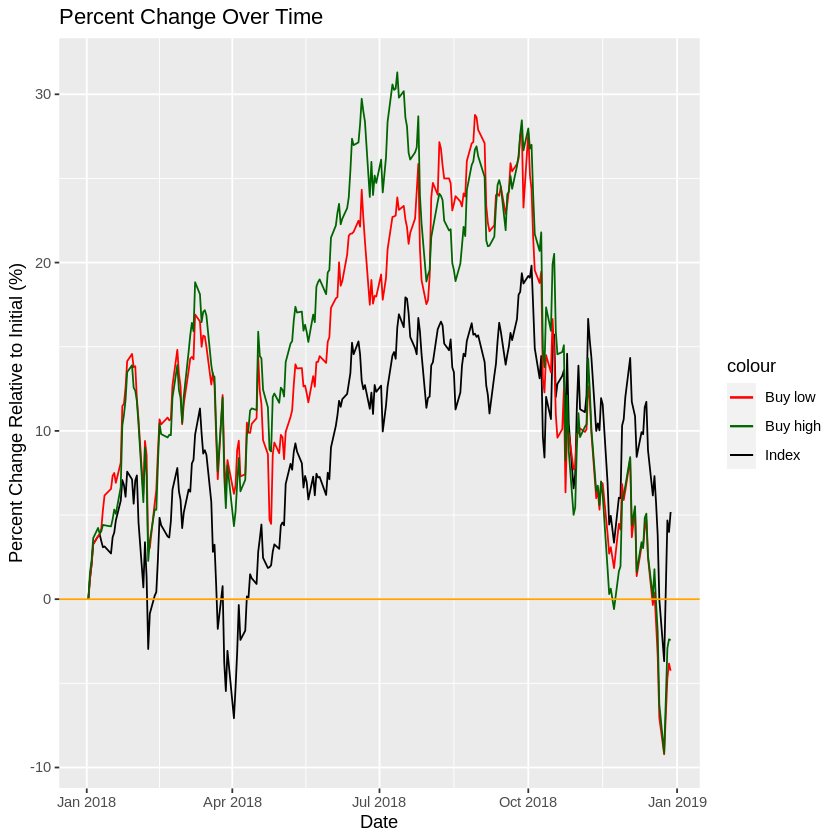

In [23]:

ggplot() +
  geom_line(data = low_df, aes(x = Date, y = Percent, color = "Low"), linetype = "solid") +
  geom_line(data = high_df, aes(x = Date, y = Percent, color = "High"), linetype = "solid") +
  geom_line(data = index_df, aes(x = Date, y = Percent, color = "Index"), linetype = "solid") +
  geom_hline(yintercept = 0, linetype = "solid", color = "orange") +
  labs(x = "Date", y = "Percent Change Relative to Initial (%)", title = "Percent Change Over Time") +
  scale_color_manual(values = c("red", "darkgreen", "black"), labels = c("Buy low", "Buy high", "Index")) +
  theme(legend.position = "right")

Part 2: Evaluating two investment plans with JPY/USD

In [24]:
# Making JPYUSD the same as Stocks
filtered_JPYUSD <- data.frame()
for (index in 1:(nrow(JPYUSD))) {

  data_from_JPYUSD <- JPYUSD[index, "Date"]$Date[1]
  data_from_stock <- universe[["IBM"]][["Date"]]
  data_from_stock <- as.Date(data_from_stock)
  result <- data_from_JPYUSD %in% data_from_stock

  if (result) {
    filtered_JPYUSD <- rbind(filtered_JPYUSD, JPYUSD[index, ])
  }
}


In [25]:
# Check Dividend Script

universe <- list(
  "IBM" = IBM,
  "MSFT" = MSFT,
  "GOOG" = GOOG,
  "AAPL" = AAPL,
  "AMZN" = AMZN,
  "META" = META,
  "NFLX" = NFLX,
  "TSLA" = TSLA,
  "ORCL" = ORCL,
  "SAP" = SAP,
  "JPYUSD" = filtered_JPYUSD
)

dividends <- lapply(universe, find_dividends)

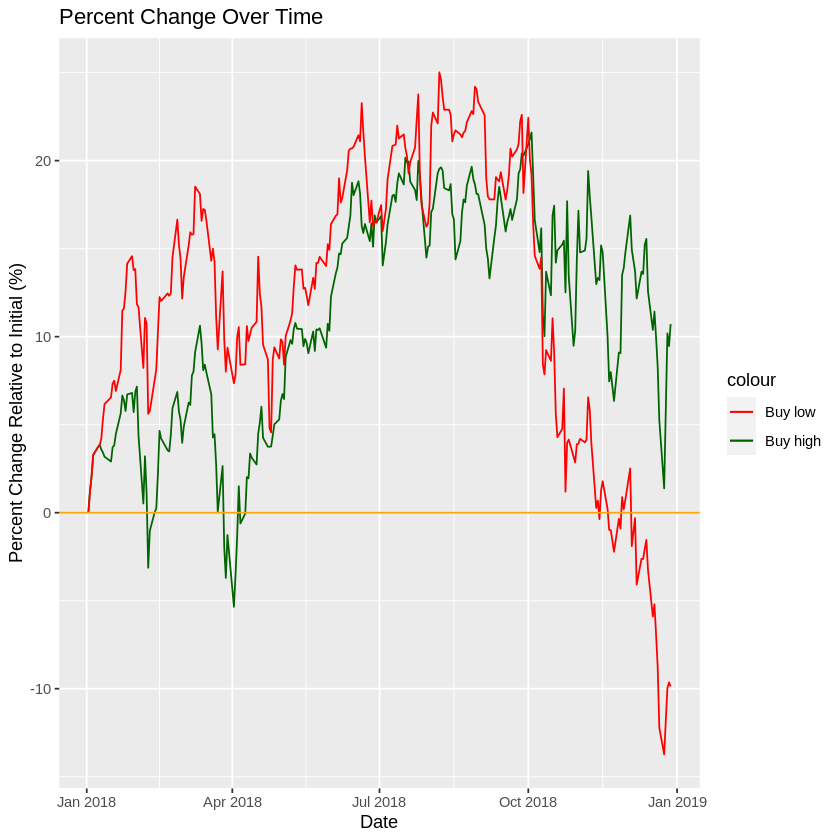

In [26]:

results <- list()

# Preprocessing
data_processing <- function(df, days) {
  result <- df[c(1, which((1:(nrow(df) - 1)) %% days == 0) + 1), ]
  if (nrow(df) - 1 %% days != 0) {
    result <- rbind(result, df[nrow(df), ])
  }
  result <- result %>% mutate(price_difference = (`Adj Close` - lag(`Adj Close`, n = 1)) / lag(`Adj Close`, n = 1) * 100)
  return(result)
}

# Preprocessing for 5 day rebalance
processed_universe <- lapply(universe, data_processing, 5)
processed_universe[["JPYUSD"]]$price_difference <- -processed_universe[["JPYUSD"]]$price_difference

# Initial Condition
current <- 5000000
initial_buy <- list("MSFT", "GOOG", "AAPL", "AMZN", "IBM")
budget <- current / length(initial_buy)

# Run the two investment plans
low_df = run_script("low", current, initial_buy, budget, TRUE)
high_df = run_script("high", current, initial_buy, budget, TRUE)

# Post processing
low_df$Percent <- (low_df$MTM / 5000000 * 100) - 100
high_df$Percent <- (high_df$MTM / 5000000 * 100) - 100

# Line plot of the Percent Change Relative to Initial
ggplot() +
  geom_line(data = low_df, aes(x = Date, y = Percent, color = "Low"), linetype = "solid") +
  geom_line(data = high_df, aes(x = Date, y = Percent, color = "High"), linetype = "solid") +
  geom_hline(yintercept = 0, linetype = "solid", color = "orange") +
  labs(x = "Date", y = "Percent Change Relative to Initial (%)", title = "Percent Change Over Time") +
  scale_color_manual(values = c("red", "darkgreen"), labels = c("Buy low", "Buy high")) +
  theme(legend.position = "right")



Part 3: Finding optimal rebalance intervals to maximize gains

In [27]:
results <- list()

# Optimizing to check rebalancing between 1 and 60 days
for (days in seq(1, 61, by = 1)) {
  # Preprocessing - changes our rebalance df based on the days
  data_processing <- function(df, days) {
    result <- df[c(1, which((1:(nrow(df) - 1)) %% days == 0) + 1), ]
    if (nrow(df) - 1 %% days != 0) {
      result <- rbind(result, df[nrow(df), ])
    }
    result <- result %>% mutate(price_difference = (`Adj Close` - lag(`Adj Close`, n = 1)) / lag(`Adj Close`, n = 1) * 100)
    return(result)
  }

  # Create new rebalance df
  processed_universe <- lapply(universe, data_processing, days)

  # Post process the JPYUSD as it is inversed
  processed_universe[["JPYUSD"]]$price_difference <- -processed_universe[["JPYUSD"]]$price_difference

  # Initial Condition
  current <- 5000000
  initial_buy <- list("MSFT", "GOOG", "AAPL", "AMZN", "IBM")
  budget <- current / length(initial_buy)

  # Run the script produced earlier, but with jpy param set to true
  low_df = run_script("low", current, initial_buy, budget, TRUE)
  high_df = run_script("high", current, initial_buy, budget, TRUE)

  # Post processing
  low_df$Percent <- (low_df$MTM / 5000000 * 100) - 100
  high_df$Percent <- (high_df$MTM / 5000000 * 100) - 100

  # Create a dictionary of days and [low_df, high_df]
  day_data <- list(low_df = low_df$Percent[length(low_df$Percent)], high_df = high_df$Percent[length(high_df$Percent)])
  results[[paste(days, sep = "")]] <- day_data
}


In [28]:
high_values <- unlist(lapply(results, function(x) x$high_df))
low_values <- unlist(lapply(results, function(x) x$low_df))

# Find the maximum value
max_high <- max(high_values)
max_low <- max(low_values)
min_high <- min(high_values)
min_low <- min(low_values)

# Find the day associated with the maximum value
max_high_day <- names(results)[which.max(high_values)]
max_low_day <- names(results)[which.max(low_values)]
min_high_day <- names(results)[which.min(high_values)]
min_low_day <- names(results)[which.min(low_values)]

# Print the maximum value and associated day
print("Optimal")
print(paste("Buy High: Rebalance every", max_high_day, "days", round(max_high, 2), "% Change from Initial"))
print(paste("Buy Low: Rebalance every", max_low_day, "days", round(max_low, 2), "% Change from Initial"))
print("Least Optimal")

print(paste("Buy High: Rebalance every", min_high_day, "days", round(min_high, 2), "% Change from Initial"))
print(paste("Buy Low: Rebalance every", min_low_day, "days", round(min_low, 2), "% Change from Initial"))

[1] "Optimal"
[1] "Buy High: Rebalance every 12 days 8.45 % Change from Initial"
[1] "Buy Low: Rebalance every 59 days 18.54 % Change from Initial"
[1] "Least Optimal"
[1] "Buy High: Rebalance every 8 days -14.66 % Change from Initial"
[1] "Buy Low: Rebalance every 29 days -10.09 % Change from Initial"


In [29]:
# Dateframe the ending percent change of each iteration

high_values_df = as.data.frame(high_values)
high_values_df <- high_values_df %>% rownames_to_column(var = "index")
low_values_df = as.data.frame(low_values)
low_values_df <- low_values_df %>% rownames_to_column(var = "index")

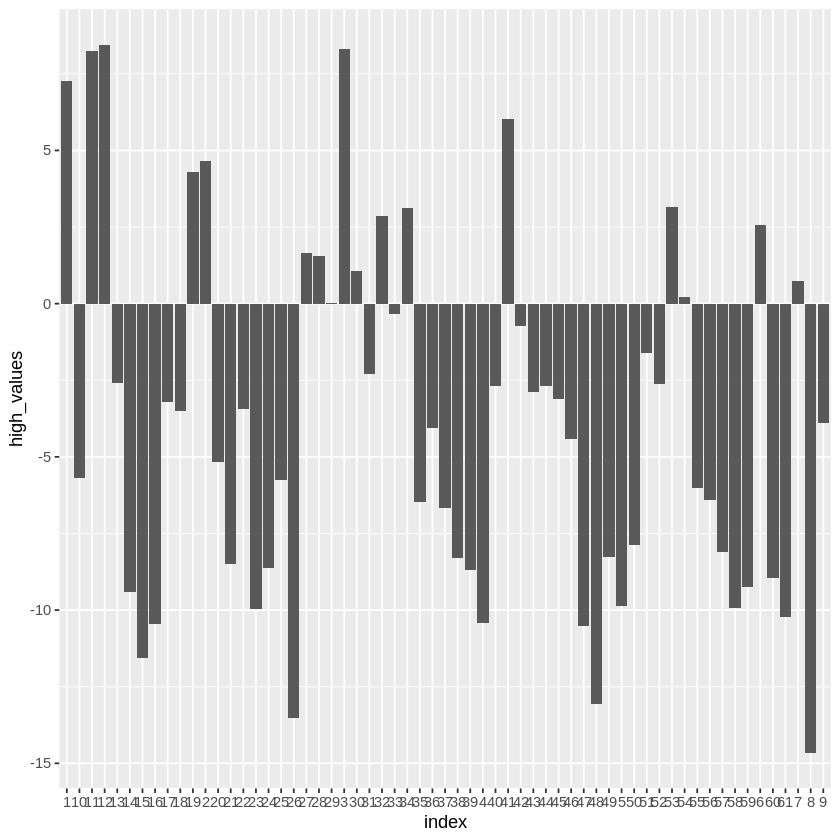

In [30]:
# Plot the percentages of buy high investment strat
ggplot() +
  geom_col(data = high_values_df, aes(x = index, y = high_values))

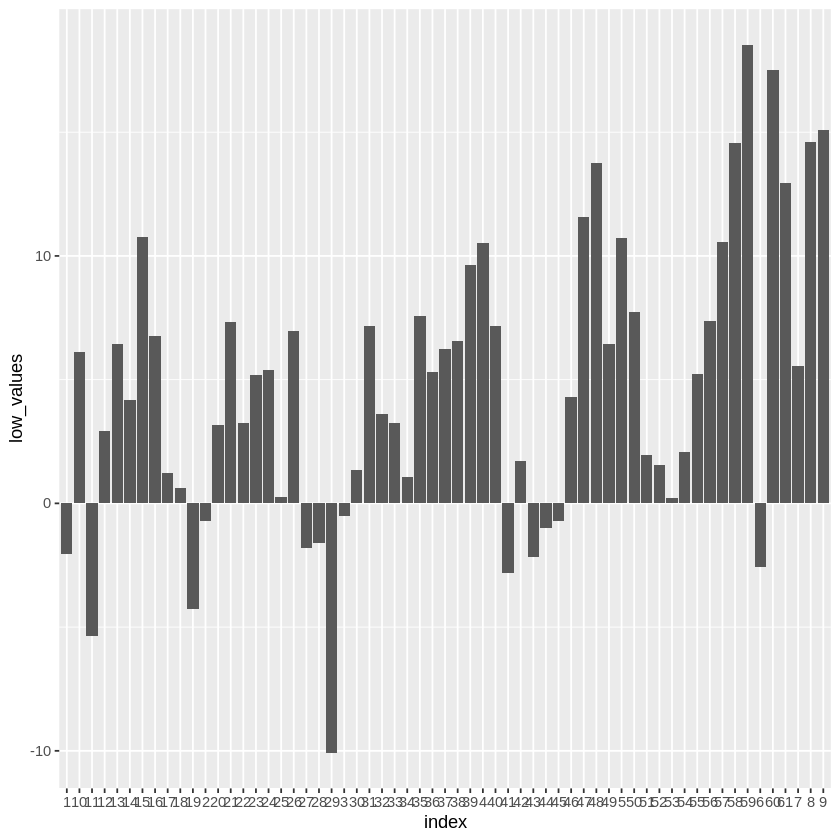

In [31]:
# Plot the percentages of buy low investment strat
ggplot() +
    geom_col(data = low_values_df, aes(x = index, y = low_values))